# Case Study 3 - Select optimal survey locality
## Description 
As a researcher, I want the ability to design a study/field campaign in advance, so that the best results can be obtained from that study/campaign. 
## Case Breakdown 
- **Actors:** Researcher
- **Goals:** Design a campaign based on maximising variation between study sites
- **Scope:** Regional, plot-based
## Generalised case
I want to analyse a suite of spatial variables for a set of candidate locations so I can find a subset that maximises the spread across environments.
## Comparable cases
- I want to combine a suite of environmental variables, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5) and soils (pH, N, K, structure) for N (e.g. 50) candidate sites and then select the five sites that maximise spread across different environmental conditions.
- I have a set of study sites in an area and wish to know the best location for adding one more, based on ensuring that the new site adds as much as possible to the range of environments studied.
## Stakeholders 
- **Name:** Donald Hobern
- **Contact:** donald.hobern@adelaide.edu.au


## Data Sources
The primary goal for this case study is to demonstrate being able to import a set of environmental values for different sites and then use these to identify a subset that maximises spread across the various environmental dimensions.

This is a simple implementation that uses four environmental attributes imported for all Australia (or a subset like NSW) at a moderate grid scale:

1. Soil water pH (0-5cm) - see https://esoil.io/TERNLandscapes/Public/Pages/SLGA/ProductDetails-SoilAttributes.html
2. Soil organic carbon (0-5cm) - see https://esoil.io/TERNLandscapes/Public/Pages/SLGA/ProductDetails-SoilAttributes.html
3. Annual mean rainfall
4. Annual mean temperature

Notes:
- The first two can be imported directly as layers from SLGA. The others are probably available online in suitable forms at a slightly better grid resolution and can also be imported directly.
- An enhancement to this case study would be to start by importing annual layers (say for the last 5 or 10 years) for each of the weather variables and then generating the mean, maximum and minimum respectively for each pixel across the selected years. These computed results would then be the inputs to the main datacube.
- Latitude and longitude can also be incorporated later as additional variables.

## Data Transformation and Data Cube generation

In [1]:
from mccn.client import MCCN
import matplotlib.pyplot as plt

engine = MCCN(endpoint="generated/collection.json", shape=100, dtype="uint8")

In [2]:
all_data = engine.load()

In [3]:
all_data

<xarray.Dataset> Size: 1MB
Dimensions:              (y: 100, x: 100, time: 2)
Coordinates:
  * y                    (y) float64 800B -28.08 -28.17 -28.27 ... -37.33 -37.42
  * x                    (x) float64 800B 141.0 141.1 141.2 ... 153.5 153.6
  * time                 (time) datetime64[ns] 16B 2009-12-30T13:00:00 2022-0...
    spatial_ref          int32 4B 4326
Data variables: (12/17)
    soc_0_5_mean         (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_5_15_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_15_30_mean       (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_0_10_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_10_30_mean       (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_0_30_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ...                   ...
    ph_100_200_mean      (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ph_0_10_mean         (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ph_10_30_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ph_0_30_mean         (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    rainfall_mm          (time, y, x) float32 80kB 0.0 0.0 0.0 ... nan nan nan
    temperature_celsius  (time, y, x) float32 80kB 0.0 0.0 0.0 ... nan nan nan

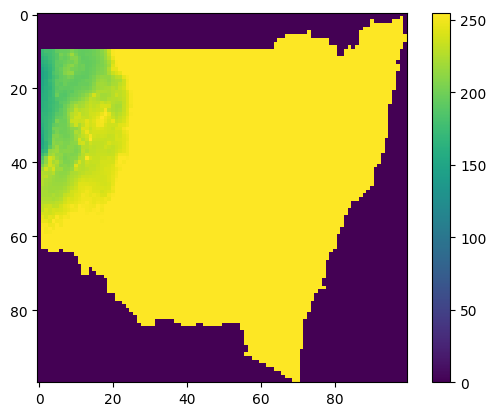

In [4]:
plt.imshow(all_data.rainfall_mm.values[0, :, :])
plt.colorbar()
plt.show()

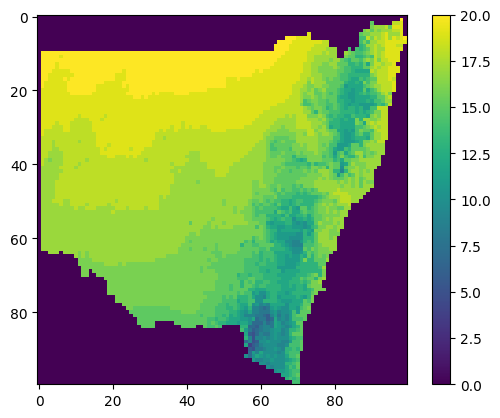

In [5]:
plt.imshow(all_data.temperature_celsius.values[0, :, :])
plt.colorbar()
plt.show()

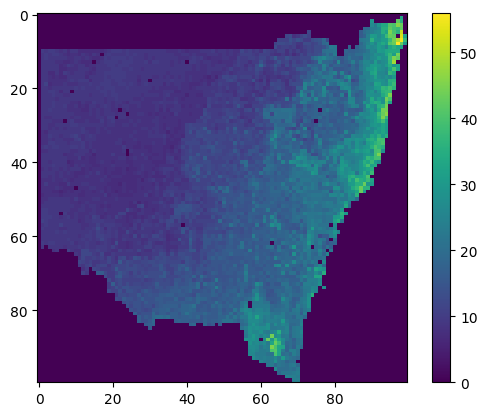

In [6]:
plt.imshow(all_data.soc_0_30_mean.values[1, :, :])
plt.colorbar()
plt.show()

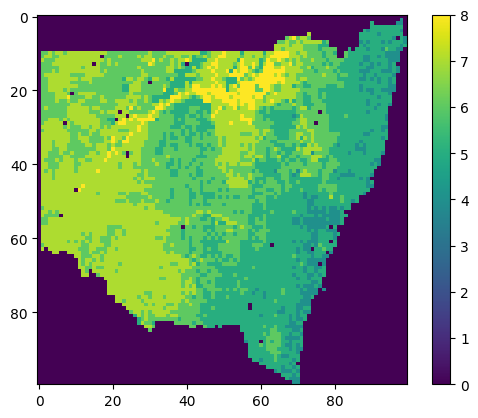

In [7]:
plt.imshow(all_data.ph_0_30_mean.values[1, :, :])
plt.colorbar()
plt.show()

## Data Analysis

1. Select 10 random positions across the space selected.
2. Goal is to find the optimal position for an 11th site to maximise variation across the environment.
3. Scale all environmental layers on a 0.0 to 1.0 scale based on the actual range of values in the layer.
4. Treat these layer values as orthogonal axes in a 5-dimensional space. The environmental distance between any two points will be the fifth root of the product of these five numbers.
5. Generate 10 new layers, each representing the environmental distance between every pixel and one of the 10 current points.
6. Build a new layer that holds the smallest value for each pixel from these 10 layers - that is the environmental distance between that point and the environmentally closest of the 10 current points.
7. Find which pixel has the highest value in this final layer - it represents the most environmentally distant point and the one that should next be surveyed.

In [8]:
import numpy as np

def environmental_distance(point_values, layer_values):
    """Calculate environmental distance in 4D space"""
    differences = np.power(np.abs(point_values - layer_values), 4)
    return np.power(np.prod(differences, axis=-1), 1/4)


In [9]:
all_data.temperature_celsius.values[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 20.,  0.],
       [ 0.,  0.,  0., ..., 18., 19.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
      shape=(100, 100), dtype=float32)

In [10]:
selected_layers = [
    all_data.soc_0_30_mean.values[1], 
    all_data.ph_0_30_mean.values[1],
    all_data.rainfall_mm.values[0],
    all_data.temperature_celsius.values[0]
]

In [11]:
layer_values = np.stack(selected_layers, axis=-1)

layer_values

array([[[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.],
        [ 33.,   4., 255.,  20.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [ 42.,   4., 255.,  18.],
        [ 35.,   4., 255.,  19.],
        [  0.,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        .

In [12]:
# Stack layers into a single array
layer_values = np.stack(selected_layers, axis=-1)

# Create valid mask (where we have data for all layers)
# Exclude both NaN and zero values for SOC and pH (indices 0 and 1)
valid_mask = (
    ~np.any(np.isnan(layer_values), axis=-1) &  # No NaN values
    (layer_values[..., 0] > 0) &                # SOC > 0
    (layer_values[..., 1] > 0)                  # pH > 0
)

valid_indices = np.where(valid_mask)
valid_positions_all = list(zip(valid_indices[0], valid_indices[1]))


In [13]:
n_valid = len(valid_positions_all)
print(f"Found {n_valid} valid positions in the data")

Found 6346 valid positions in the data


In [14]:
import random
if n_valid == 0:
    print("Error: No valid positions found. Cvheck your data for NaN values.")
else:
    # Use all valid positions if less than 10, otherwise sample 10
    n_samples = min(n_valid, 10)
    valid_positions = random.sample(valid_positions_all, n_samples)
    
    print(f"\nUsing {n_samples} sampling positions")

    # Calculate distance layers for each point
    distance_layers = []
    for pos in valid_positions:
        point_values = layer_values[pos[0], pos[1]]
        distances = environmental_distance(point_values, layer_values)
        distance_layers.append(distances)

    # Build minimum distance layer
    distance_layers = np.stack(distance_layers, axis=0)
    min_distances = np.nanmin(distance_layers, axis=0)

    # Find highest value pixel
    min_distances[~valid_mask] = np.nan  # Ensure we don't select invalid positions
    optimal_position = np.unravel_index(np.nanargmax(min_distances), min_distances.shape)
    max_min_distance = min_distances[optimal_position]

    for i, pos in enumerate(valid_positions, 1):
        print(f"Point {i}: Row: {pos[0]}, Col: {pos[1]}")
        values = layer_values[pos[0], pos[1]]
        print(f"SOC: {values[0]:.3f}, pH: {values[1]:.3f}, "
              f"Rainfall: {values[2]:.3f}, Temp: {values[3]:.3f}")

    print(f"Optimal new sampling location:")
    print(f"Row: {optimal_position[0]}, Col: {optimal_position[1]}")
    opt_values = layer_values[optimal_position[0], optimal_position[1]]
    print(f"Environmental values at optimal point:")
    print(f"SOC: {opt_values[0]:.3f}, pH: {opt_values[1]:.3f}, "
          f"Rainfall: {opt_values[2]:.3f}, Temp: {opt_values[3]:.3f}")
    print(f"Environmental distance score: {max_min_distance:.5f}")


Using 10 sampling positions
Point 1: Row: 73, Col: 51
SOC: 15.000, pH: 5.000, Rainfall: 255.000, Temp: 15.000
Point 2: Row: 27, Col: 86
SOC: 19.000, pH: 5.000, Rainfall: 255.000, Temp: 13.000
Point 3: Row: 18, Col: 94
SOC: 26.000, pH: 5.000, Rainfall: 255.000, Temp: 18.000
Point 4: Row: 31, Col: 42
SOC: 12.000, pH: 6.000, Rainfall: 255.000, Temp: 18.000
Point 5: Row: 32, Col: 39
SOC: 8.000, pH: 5.000, Rainfall: 255.000, Temp: 18.000
Point 6: Row: 29, Col: 67
SOC: 21.000, pH: 5.000, Rainfall: 255.000, Temp: 17.000
Point 7: Row: 45, Col: 74
SOC: 21.000, pH: 5.000, Rainfall: 255.000, Temp: 16.000
Point 8: Row: 28, Col: 30
SOC: 8.000, pH: 8.000, Rainfall: 255.000, Temp: 19.000
Point 9: Row: 44, Col: 34
SOC: 7.000, pH: 6.000, Rainfall: 255.000, Temp: 18.000
Point 10: Row: 24, Col: 19
SOC: 9.000, pH: 6.000, Rainfall: 233.000, Temp: 19.000
Optimal new sampling location:
Row: 68, Col: 11
Environmental values at optimal point:
SOC: 10.000, pH: 7.000, Rainfall: 0.000, Temp: 0.000
Environmental 

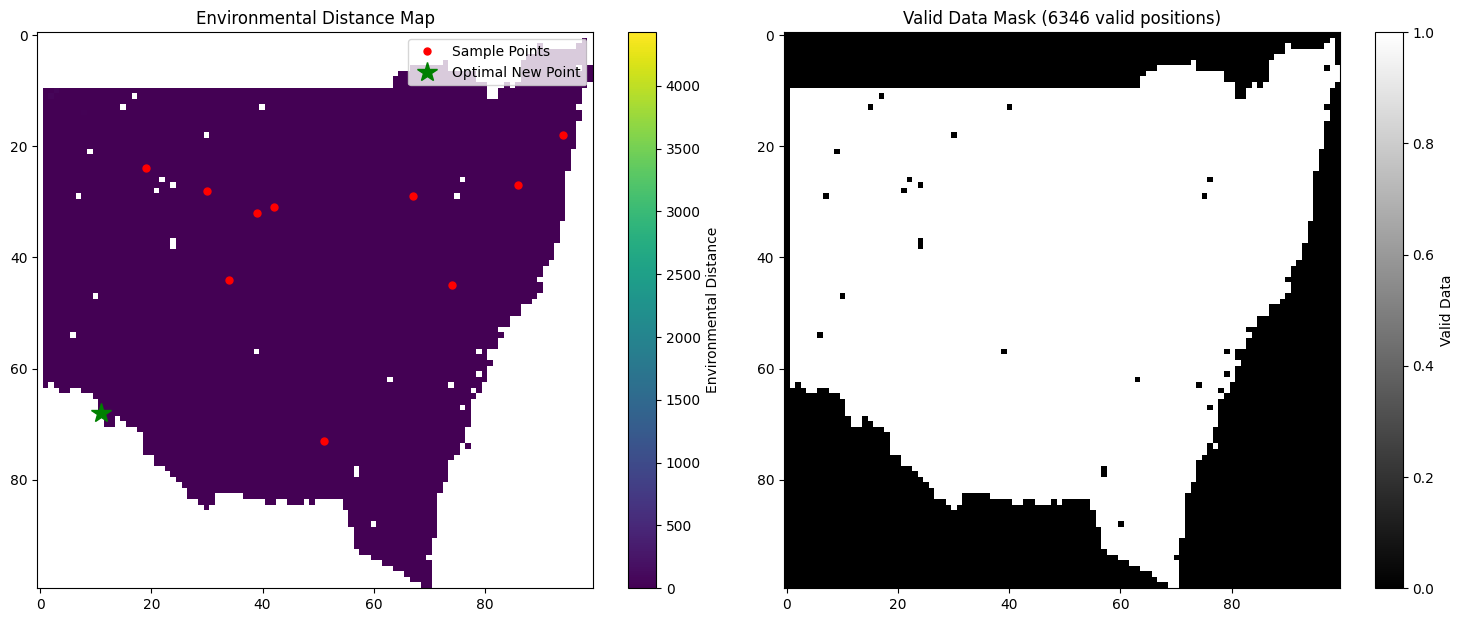

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot distance map
masked_distances = np.ma.masked_array(min_distances, ~valid_mask)
im1 = ax1.imshow(masked_distances, cmap='viridis')
plt.colorbar(im1, ax=ax1, label='Environmental Distance')

ax1.plot([p[1] for p in valid_positions], [p[0] for p in valid_positions], 'r.', 
         markersize=10, label='Sample Points')

ax1.plot(optimal_position[1], optimal_position[0], 'g*', 
         markersize=15, label='Optimal New Point')

ax1.legend()
ax1.set_title('Environmental Distance Map')

im2 = ax2.imshow(valid_mask, cmap='gray')
plt.colorbar(im2, ax=ax2, label='Valid Data')
ax2.set_title(f'Valid Data Mask ({n_valid} valid positions)')

plt.tight_layout()
plt.show()

# print("Sample Point Positions:")
# for i, pos in enumerate(valid_positions):
#     print(f"Point {i+1}: Row={pos[0]}, Column={pos[1]}")

# print("Optimal Point Position:")
# print(f"Row={optimal_position[0]}, Column={optimal_position[1]}")

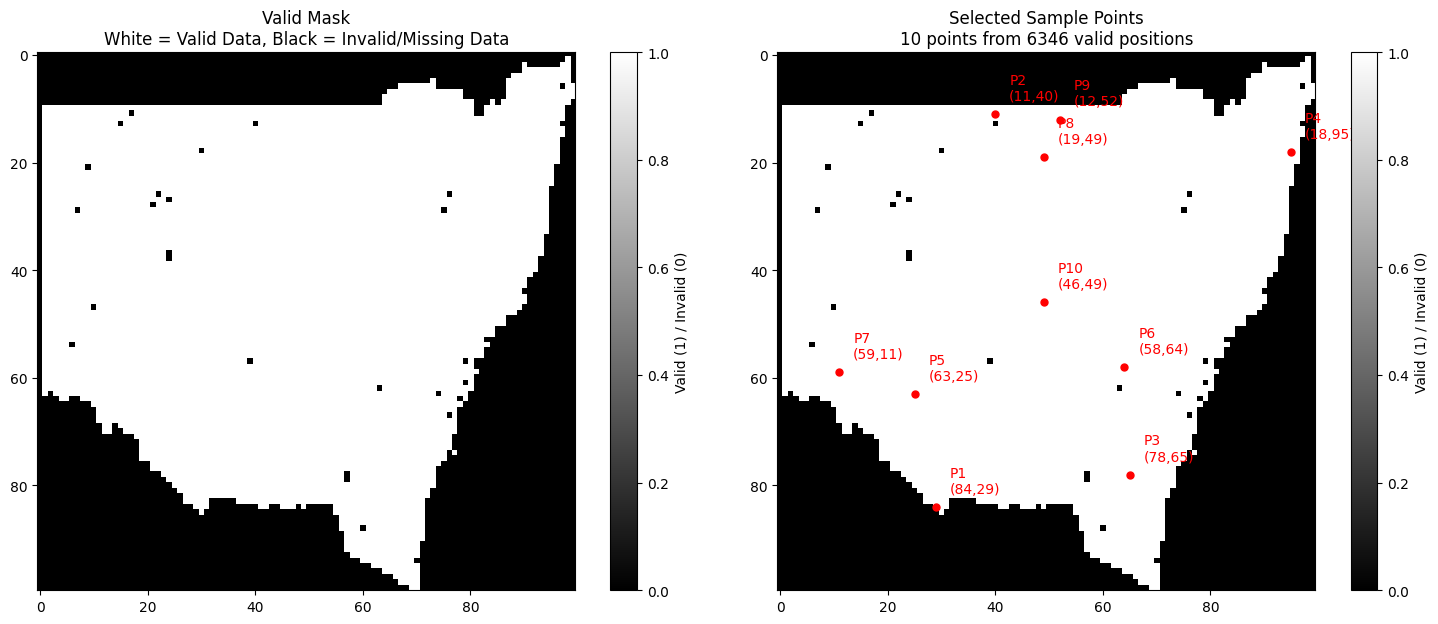

Total positions in grid: 10000
Number of valid positions: 6346
Percentage of valid positions: 63.5%

Selected sample points:
Point 1: Row=84, Column=29
  Environmental values:
  SOC: 16.000
  pH: 7.000
  Rainfall: 255.000
  Temperature: 15.000

Point 2: Row=11, Column=40
  Environmental values:
  SOC: 9.000
  pH: 6.000
  Rainfall: 255.000
  Temperature: 20.000

Point 3: Row=78, Column=65
  Environmental values:
  SOC: 18.000
  pH: 5.000
  Rainfall: 255.000
  Temperature: 12.000

Point 4: Row=18, Column=95
  Environmental values:
  SOC: 35.000
  pH: 4.000
  Rainfall: 255.000
  Temperature: 18.000

Point 5: Row=63, Column=25
  Environmental values:
  SOC: 8.000
  pH: 7.000
  Rainfall: 255.000
  Temperature: 17.000

Point 6: Row=58, Column=64
  Environmental values:
  SOC: 16.000
  pH: 5.000
  Rainfall: 255.000
  Temperature: 13.000

Point 7: Row=59, Column=11
  Environmental values:
  SOC: 9.000
  pH: 7.000
  Rainfall: 255.000
  Temperature: 17.000

Point 8: Row=19, Column=49
  Environme

In [16]:
# For detailed data range in valid positions

import numpy as np
import matplotlib.pyplot as plt
import random

# Plot the valid_mask and some example positions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Show the valid_mask
im1 = ax1.imshow(valid_mask, cmap='gray')
ax1.set_title('Valid Mask\nWhite = Valid Data, Black = Invalid/Missing Data')
plt.colorbar(im1, ax=ax1, label='Valid (1) / Invalid (0)')

# Get valid positions
valid_positions = list(zip(*np.where(valid_mask)))
n_valid = len(valid_positions)

# Randomly select 10 positions (or less if fewer valid positions exist)
n_samples = min(10, n_valid)
selected_positions = random.sample(valid_positions, n_samples)

# Plot 2: Show selected points on the mask
im2 = ax2.imshow(valid_mask, cmap='gray')
plt.colorbar(im2, ax=ax2, label='Valid (1) / Invalid (0)')

# Plot and label the selected points
for i, pos in enumerate(selected_positions):
    ax2.plot(pos[1], pos[0], 'r.', markersize=10)
    ax2.annotate(f'P{i+1}\n({pos[0]},{pos[1]})', 
                (pos[1], pos[0]), 
                xytext=(10, 10),
                textcoords='offset points',
                color='red')

ax2.set_title(f'Selected Sample Points\n{n_samples} points from {n_valid} valid positions')

plt.tight_layout()
plt.show()

# Print details about the valid positions
print(f"Total positions in grid: {valid_mask.shape[0] * valid_mask.shape[1]}")
print(f"Number of valid positions: {n_valid}")
print(f"Percentage of valid positions: {(n_valid/(valid_mask.shape[0] * valid_mask.shape[1])*100):.1f}%")

print("\nSelected sample points:")
for i, pos in enumerate(selected_positions):
    print(f"Point {i+1}: Row={pos[0]}, Column={pos[1]}")
    # Print environmental values at this position
    values = layer_values[pos[0], pos[1]]
    print(f"  Environmental values:")
    print(f"  SOC: {values[0]:.3f}")
    print(f"  pH: {values[1]:.3f}")
    print(f"  Rainfall: {values[2]:.3f}")
    print(f"  Temperature: {values[3]:.3f}\n")